Once we have collected the textual and financial data (see Data_Collection.ipynb for details), we need to create a model. Initially, we considered a model with two inputs (text and tabular data simultaneously), but it proved unsuitable for this task. Therefore, in this notebook, we will train an NLP model on Earnings Call transcripts. Subsequently, in Financials_model.ipynb, we will use the NLP model’s predictions and corresponding financials as a training dataset.

# Imports

In [1]:
import os
import gc
import requests
from datetime import datetime
import pandas as pd
from datetime import timedelta
import requests
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import time
import ast
import json
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle
import json
import random
import matplotlib.pyplot as plt

/tmp/ipykernel_22044/2503562350.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-10-08 10:02:57.991898: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# Data Processing

In [2]:
df = pd.read_pickle('transcripts.pkl')

**Creating tokenizer in order to translate words into numbers so that neural network can work with them**

In [3]:
# oov_tok = "<OOV>"
# tokenizer = Tokenizer(oov_token=oov_tok)
# tokenizer.fit_on_texts(transcripts.transcript)
# pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [4]:
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

In [5]:
#creating a test set for the future model
year = 2018
month = 3
test = df[(df.time >= pd.to_datetime(f'{month+3}-01-{year}').date())]
df = df[(df.time < pd.to_datetime(f'{month}-01-{year}').date())] 

# Machine Learning

__Task and its influence on chosen model and metrics__


We decided to use a classification model since our main interest is identifying stocks likely to grow, rather than predicting the extent of growth, making regression less suitable. As we want our model to be pretty conservative, we will set our target to 1 when a stock has grown during a 90-day period, and 0 otherwise. We can also adjust the model's risk level by, for example, setting the target to 1 only when a stock has grown by 10% or more.

We decided to use precision as our evaluation metric because the most important factor is the proportion of stocks in our “portfolio” that grew. The accuracy of our predictions for the rest of the stocks is less critical. We will use precision on the 100 stocks (not as big to be always too close to overall market in terms of performance but enough to build diversified portfolio) with the highest probability of growth in each period and compare this with the performance of all stocks (Because if 70% of stocks were growing in the entire market, selecting 60% of growing stocks for our portfolio should be considered a failure, despite being more than half, since it is less than a random guess). 

We do not use profit as a metric for model validation because it can be heavily influenced by outliers. We will asses profits in the very end when we will be drawing conclusions about the model. 

__Cross-validation and model assesment__

Traditional cross-validation is not feasible due to the time dependency in our data. Predicting the past at the expense of the future could introduce bias and mislead model assessment. To address this, we will adopt a time-dependent approach: training the model on known data up to a certain point, testing it on the subsequent 3 months, then shifting forward by another 3 months, and retraining. This process generates predictions from models trained on different datasets. Consecutive months cannot be used for training and testing since our target (stock price change in 90 days) is unknown. Thus, a 3-month pause is implemented between training and validation sets to account for this temporal gap.

In [6]:
def backtest(ped, model, num_epochs, ml = 9000):
    # spliting into train and test with the gap mentioned above if it's the first ever quarter
    if ped == 0: 
        train = df[(df.time < pd.to_datetime(f'01-03-2017').date()) ] 
        valid = df[(df.time > train.time.max() + timedelta(days = 90)) & (df.time < train.time.max() + timedelta(days = 180))]  
    else:
    # if it's not the first ever quarter spliting into train and test starting with previos ending date
        valid = df[(df.time >= ped + timedelta(1)) & (df.time <= ped+timedelta(90))]
        train = df[(df.time < valid.time.min() - timedelta(90)) ] 
                                                      
    ped = valid.time.max()                                        
    
                                                      
    # tokenizing textual data
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    training_padded = pad_sequences(tokenizer.texts_to_sequences(train.transcript), maxlen=max_length, padding=padding_type, truncating=trunc_type)
    valid_padded = pad_sequences(tokenizer.texts_to_sequences(valid.transcript), maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    # valid = valid.drop(columns = 'transcript')
    vocab_size = len(tokenizer.word_index) + 1

    #setting the target                                                
    train['y'] = 0
    train['y'][train.change > 1] = 1
    valid['y'] = 0
    valid['y'][valid.change > 1] = 1
    y_train = np.array(train.y)
    # train = []
                                                      
    #compiling and fitting the model                                                

    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)
    num_epochs = num_epochs
    opt = 'Adam'
    model.compile(loss='binary_crossentropy',optimizer = opt, metrics=['AUC'])
    model.fit(training_padded, y_train, epochs=num_epochs, verbose=0, batch_size = 128,  validation_data = (valid_padded, np.array(valid.y))) 
    valid['proba'] = model.predict(valid_padded, verbose = 0)
    
    # selecting top 100 stocks and calculating precision for this portfolio and the entire market
                                                      
    top = valid.sort_values(by = 'proba', ascending = False).iloc[range(100)]
    precision = top.y.mean()
    op = valid.y.mean()
    
    return ped, precision, op

__Testing different architectures__

We need to test several architecture options, text preprocessing techniques, and hyperparameters to choose the best one for this task. Since the transcripts are very long, we will avoid advanced options like LSTM or Transformers, as they require very powerful machines to process them within a reasonable timeframe, which are not availible for us.

In [7]:
import keras
import warnings
fin = []
warnings.filterwarnings("ignore")  
vocab_size = len(tokenizer.word_index) + 1
max_length = 9000
embedding_dim = 8

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)


num_epochs = 5

ped = 0
precisions = []
warnings.filterwarnings("ignore")
for i in range(4):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    bk = backtest(ped, model, num_epochs, ml = 9000)
    ped = bk[0]
    precisions.append(bk[1]-bk[2])

np.mean(precisions)

0.10625234780653267

In [8]:
#trying different architecture
import keras
import warnings
fin = []
warnings.filterwarnings("ignore")  
vocab_size = len(tokenizer.word_index) + 1
max_length = 9000
embedding_dim = 8
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)


num_epochs = 5

ped = 0
precisions = []
warnings.filterwarnings("ignore")
for i in range(4):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    bk = backtest(ped, model, num_epochs, ml = 9000)
    ped = bk[0]
    precisions.append(bk[1]-bk[2])

np.mean(precisions)

0.11125234780653268

In [9]:
#trying different architecture
import keras
import warnings
fin = []
warnings.filterwarnings("ignore")  
vocab_size = len(tokenizer.word_index) + 1
max_length = 9000
embedding_dim = 8
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)


num_epochs = 4

ped = 0
precisions = []
warnings.filterwarnings("ignore")
for i in range(4):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(800, activation='relu'),
        tf.keras.layers.Dense(400, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    bk = backtest(ped, model, num_epochs, ml = 9000)
    ped = bk[0]
    precisions.append(bk[1]-bk[2])

np.mean(precisions)

0.07875234780653265

In [10]:
#trying so far the best architecture with embedding dimension 4 instead of 8
import keras
import warnings
fin = []
warnings.filterwarnings("ignore")  
vocab_size = len(tokenizer.word_index) + 1
max_length = 9000
embedding_dim = 4
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)


num_epochs = 4

ped = 0
precisions = []
warnings.filterwarnings("ignore")
for i in range(4):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    bk = backtest(ped, model, num_epochs, ml = 9000)
    ped = bk[0]
    precisions.append(bk[1]-bk[2])

np.mean(precisions)

0.0637523478065327

In [11]:
from nltk.corpus import stopwords

def remove_stopwords(text):
    text = text.split(' ')
    filtered_text = [word for word in text if word not in stopwords.words('english')]
    return ' '.join(filtered_text)
df.transcript = df.transcript.apply(remove_stopwords)

In [12]:
#trying so far the best architecture with removed stopwords

import keras
import warnings
fin = []
warnings.filterwarnings("ignore")  
vocab_size = len(tokenizer.word_index) + 1
max_length = 9000
embedding_dim = 8
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)


num_epochs = 5

ped = 0
precisions = []
warnings.filterwarnings("ignore")
for i in range(4):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    bk = backtest(ped, model, num_epochs, ml = 9000)
    ped = bk[0]
    precisions.append(bk[1]-bk[2])

np.mean(precisions)

0.09375234780653266

# Assesing results

As we have chosen the best model now we need to asses the results and save file for the financials model

In [13]:
# reading file once again to restore the original texts 
df = pd.read_pickle('transcripts.pkl')
year = 2018
month = 3
test = df[(df.time >= pd.to_datetime(f'{month+3}-01-{year}').date())]
df = df[(df.time < pd.to_datetime(f'{month}-01-{year}').date())] 


In [14]:
# once again fitting the best model and making presictions on the test set

import keras
import warnings
warnings.filterwarnings("ignore")  

vocab_size = len(tokenizer.word_index) + 1
max_length = 9000
embedding_dim = 8
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

training_padded = pad_sequences(tokenizer.texts_to_sequences(df.transcript), maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_padded = pad_sequences(tokenizer.texts_to_sequences(test.transcript), maxlen=max_length, padding=padding_type, truncating=trunc_type)

df['y'] = 0
df['y'][df.change > 1] = 1
y_train = np.array(df.y)

num_epochs = 5

os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

opt = 'Adam'
model.compile(loss='binary_crossentropy',optimizer = opt, metrics=['AUC'])
model.fit(training_padded, y_train, epochs=num_epochs, verbose=0, batch_size = 128) 
test['proba'] = model.predict(testing_padded, verbose = 0)

In [15]:
#calculating our portfolio and overall market precisions in each year of the test set
precesion_model, precesion_market = [], []
for i in range(2018, 2022):
    prom = test[(test.time >= pd.to_datetime(f'01-01-{i}').date()) & (test.time < pd.to_datetime(f'01-01-{i+1}').date())]
    prom['y'] = 0
    prom['y'][prom.change > 1] = 1
    precesion_model.append(prom.sort_values(by = 'proba', ascending = False).iloc[range(100)].y.mean())
    precesion_market.append(prom.y.mean())

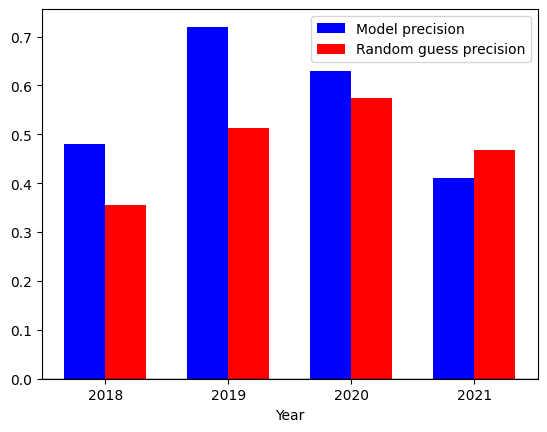

In [16]:
#graph of our portfolio and overall market precisions in each year of the test set

r = np.array([0, 0.6, 1.2, 1.8])
width = 0.2

plt.bar(r, precesion_model, color = 'b', 
        width = width,
        label='Model precision') 
plt.bar(r + width, precesion_market, color = 'r', 
        width = width, 
        label='Random guess precision') 
  
plt.xlabel("Year") 
  
plt.xticks(r + width/2,['2018','2019','2020','2021']) 
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend()
plt.axhline(y=0,linewidth=1, color='k')


plt.show()

Now we need to evaluate the model's performance in terms of profit, which was the primary goal. The comparison, once again, should be against the market, as it's not difficult to create a profitable portfolio in a growing market by random guessing. The key is to consistently outperform the market.

In [17]:
#calculating our portfolio and overall market profits in each year of the test set

profits_model, profits_market = [], []
for i in range(2018, 2022):
    prom = test[(test.time >= pd.to_datetime(f'01-01-{i}').date()) & (test.time < pd.to_datetime(f'01-01-{i+1}').date())]
    profits_model.append(prom.sort_values(by = 'proba', ascending = False).iloc[range(100)].change.mean()-1)
    profits_market.append(prom.change.mean()-1)

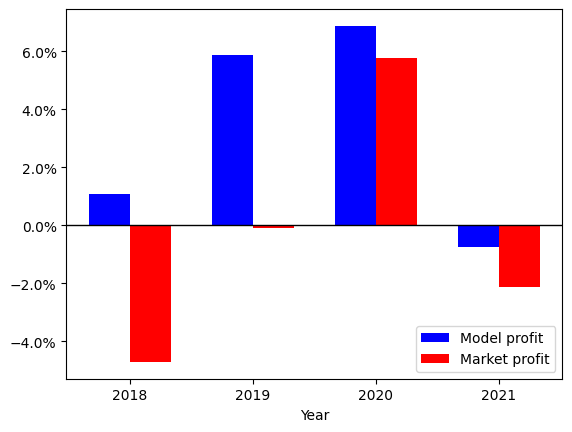

In [18]:
#graph of our portfolio and overall market profits in each year of the test set

import matplotlib.ticker as mtick
r = np.array([0, 0.6, 1.2, 1.8])
width = 0.2

plt.bar(r, profits_model, color = 'b', 
        width = width,
        label='Model profit') 
plt.bar(r + width, profits_market, color = 'r', 
        width = width, 
        label='Market profit') 
  
plt.xlabel("Year") 
  
plt.xticks(r + width/2,['2018','2019','2020','2021']) 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend()
plt.axhline(y=0,linewidth=1, color='k')


plt.show()

In [19]:
print('Average differencce between model profit and market model:', str(round((np.mean(profits_model)-np.mean(profits_market))*100, 2))+'%')
print('Average differencce between model precision and random guess:', round(np.mean(precesion_model)-np.mean(precesion_market), 3))



Average differencce between model profit and market model: 3.56%
Average differencce between model precision and random guess: 0.082


As you can see model indeed can consistently outperform the market in terms of both profit and precision, so now we only need to improve it by adding financials in the next notebook. 

# Preparing data for Statlearn 

In [20]:
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 8
max_length = 9000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

training_sequences = tokenizer.texts_to_sequences(df.transcript)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test.transcript)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)

vocab_size = len(tokenizer.word_index) + 1

df['y'] = 0
df['y'][df.change > 1] = 1

test['y'] = 0
test['y'][test.change > 1] = 1

y_train = np.array(df.y)
y_test = np.array(test.y)

num_epochs = 3
model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dense(200, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(50, activation='relu'),
tf.keras.layers.Dense(24, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['AUC'])
model.fit(training_padded, y_train, epochs=num_epochs, verbose=0) 
predicted_proba_hg = model.predict(testing_padded, verbose = 0)
test['call'] = predicted_proba_hg

In [21]:
test.drop(columns = 'transcript').to_pickle('test.pkl')